# BEES1041 Exploring the Natural World #
# Week 2 Computer Exercise - Drought in Goulburn #
***
In this Jupyter notebook you will continue to explore the drought in Goulburn, and how Pejar Dam became empty. You will use the same easily accessible data as last week, but this week you will analyse the data using R code instead of Excel. The objective of this weeks exercise is to demonstrate how to conduct exploratory data analyses in R, and to show some of the benefits of coding:
* customising analyses with functions from code libraries
* combining analyses of two different datasets
* once code cells are written, they can be run over any input data of the same form

Last week you saw how several towns in NSW have experienced water shortages, highlighted in this article from [ABC News](https://www.abc.net.au/news/2019-07-14/day-zero-approaching-as-towns-run-out-of-water/11271430?nw=0) in 2019. Goulburn was one of the towns in the story, and is around 150 km southwest of Sydney. Its water supply comes from Pejar Dam, around 20 km northwest of Goulburn, which became dry in 2006.<br><br>
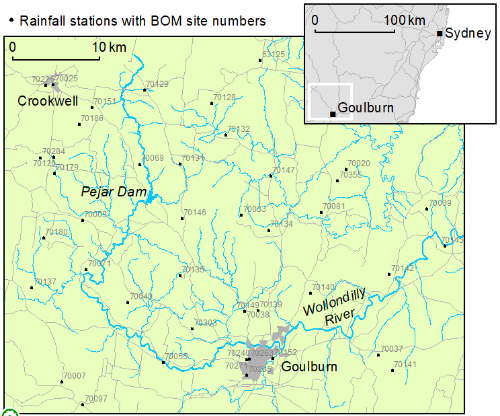<br><br>

***
### Part 1. Rainfall data ###
The CSV file that you downloaded from Moodle, called bom70069_monthlyrainfall.csv, is monthly rainfall from the Bureau of Meterology (BOM) site 70069, which is in the catchment of Pejar Dam. It was downloaded from [BOM Climate Data Online](http://www.bom.gov.au/climate/data/). It is the same data you downloaded last week to analyse in Excel. The first part of this notebook will explore how to analyse and graph this data using R, to help answer the research question.<br><br>
The next cell is a code cell, and if you click on it and run the cell with the triange play button, it will execute each line of code in the cell. The first line of code reads in the data from the CSV file with the `read.csv()` function and saves it in a data frame called `rainfall_data`. The second line uses the `colnames()` function to print the column names from the data frame.

In [ ]:
rainfall_data <- read.csv('bom70069_monthlyrainfall.csv')
colnames(rainfall_data)

If we want to graph the rainfall data as a time series, we need to combine the year and month columns into a new date column. We can access the individual columns of the data frame using the `$` sign. For example, `rainfall_data$Year` accesses the data in the Year column. The `paste()` function lets us combine the year and month into a text string that looks like a date, as long as we also add a number 1 for the day, and separate each number wiith a `-`. Then we can use the `as.Date()` function to convert these text strings into a date, and we assign these values to a new date column. The `head()` function can be used to look at the top 6 rows of the data frame, to check that the date column has been added.

In [ ]:
rainfall_data$date <- as.Date(paste(rainfall_data$Year, rainfall_data$Month, 1, sep = "-"))
head(rainfall_data)

Now we have manipulated the data into something that makes sense, we can create a plot of rainfall over time. There are many ways of plotting in R, but one common approach is to use the ggplot2 library. First you need to load that library, then you can create the plot, and then you can add data to the plot, and format it to look nice. The code might look strange, but each line is just helping to create the plot. Note how these additional functions like `geom_col` can be added to the `ggplot()` function using the `+` symbol at the end of the line.

In [ ]:
library(ggplot2)
ggplot(rainfall_data, aes(x = date, y = Precipitation)) +
       geom_col(color = "skyblue", width = 0.5) +
       labs(x = "Date", y = "Rainfall (mm)") +
       theme_bw()

The plot above lets us see how rainfall fluctuates over time, but it is hard to see any patterns. Lets add a line for the average monthly rainfall, so that we can see when it rained more or less than average. First we need to calculate the average or mean. We can see this value by typing the variable name `mean_monthly_rainfall` on the second line.

In [ ]:
mean_monthly_rainfall <- mean(rainfall_data$Precipitation)
mean_monthly_rainfall

Now we can recreate the plot and add a horizontal line at the average value using the `geom_hline()` function.

In [ ]:
ggplot(rainfall_data, aes(x = date, y = Precipitation)) +
       geom_col(color = "skyblue", width = 0.5) +
       geom_hline(yintercept = mean_monthly_rainfall, color = "red") +
       labs(x = "Date", y = "Rainfall (mm)") +
       theme_bw()

Adding the average rainfall line helps a bit, as we can now see areas where rainfall is below the average. But it is still not clear, and it might be better to smooth the data by using annual, rather than monthly rainfall. We can create a new annual rainfall data frame using the `aggregate()` function, before assigning some sensible column names.

In [ ]:
annual_data <- aggregate(rainfall_data$Precipitation, by = list(rainfall_data$Year), FUN = sum)
colnames(annual_data) <- c("year", "rainfall")
head(annual_data)

Now we can calculate the average annual rainfall, and see what the value is.

In [ ]:
mean_annual_rainfall <- mean(annual_data$rainfall)
mean_annual_rainfall
min(annual_data$year)
max(annual_data$year)

Now we can create a new graph of annual rainfall, this time as a line graph.

In [ ]:
ggplot(annual_data, aes(x = year, y = rainfall)) +
       geom_line() +
       geom_hline(yintercept = mean_annual_rainfall, color = "red") +
       labs(x = "Year", y = "Rainfall (mm)") +
       theme_bw()

The above graph does a pretty good job of showing wet and dry years that are above and below the average. But it will look better if we colour these different parts of the graph to emphasise this. First we need to define new columns for the wet and dry periods, by using the `mutate()` function from the `dplyr` library. Then we can make a plot where we colour the wet periods blue and the dry periods red, using the `geom_ribbon()` function. Note how we can leave blank lines between the code lines, to make it easier to read.

In [ ]:
library(dplyr)

annual_data <- mutate(annual_data, 
                      dry = pmin(rainfall, mean_annual_rainfall),
                      wet = pmax(rainfall, mean_annual_rainfall))

ggplot(annual_data, aes(x = year, y = rainfall)) +
       geom_ribbon(aes(ymin = mean_annual_rainfall, ymax = wet), fill = "skyblue") +
       geom_ribbon(aes(ymin = dry, ymax = mean_annual_rainfall), fill = "tomato") +
       geom_line() +
       geom_hline(yintercept = mean_annual_rainfall) +
       labs(x = "Year", y = "Rainfall (mm)") +
       theme_bw()

While the graph above is pretty good, climate scientists will tell you that it is better to calculate an index, such as the [standardized precipition index (SPI)](https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi). The SPI quantifies observed precipitation as a standardized departure from a probability distribution function that models the precipitation data. The values can be interpreted as the number of standard deviations by which the observed anomaly deviates from the long-term mean. Although it is complicated to understand, it is fairly simple to calculate in R using the Standardized Climate Indices (SCI) library. First you need to import th library using the following code cell. 

In [ ]:
library(SCI)

Now we can create a model using the `fitSCI()` function, before calculating the SPI using the `transformSCI()` function, both from the SCI library. Note that you can set the time scale for the SPI model to any number of months. I have set it to 12 months, which should be similar to the annual rainfall data graphed previously, but you can change it to shorter or longer periods. Then we need to remove the NA values that a created at the start and end of the time series using the `na.omit()` function. Then we can define wet and dry periods where the SPI is above and below zero, before creating a new plot.

In [ ]:
time_scale <- 12
spi_transform <- fitSCI(rainfall_data$Precipitation, first.mon = 1, time.scale = time_scale, distr = "gamma", p0 = TRUE)
rainfall_data$spi <- transformSCI(rainfall_data$Precipitation, first.mon = 1, obj = spi_transform)
rainfall_data <- na.omit(rainfall_data)

rainfall_data <- mutate(rainfall_data, 
                        dry = pmin(spi, 0),
                        wet = pmax(spi, 0))

ggplot(rainfall_data, aes(x = date, y = spi)) +
       geom_ribbon(aes(ymin = 0, ymax = wet), fill = "skyblue") +
       geom_ribbon(aes(ymin = dry, ymax = 0), fill = "tomato") +
       geom_line() +
       geom_hline(yintercept = 0) +
       labs(x = "Date", y = "SPI") +
       theme_bw()

There are some differences between the annual rainfall graph and the SPI graph, but they are very similar. You can clearly see the millenium drought in both, which was the long dry peirod where SPI was less than zero, which occued soon after the year 2000. This is when the Pejar Dam that supplies Goulburn with water dried out. You can also see that the SPI reached a minimum value in this period. To get the value and date of the minimum we can use the following code.

In [ ]:
min(rainfall_data$spi)
rainfall_data$date[rainfall_data$spi == min(rainfall_data$spi)]

***
### Part 2. Water area data ###
We can get data on how the water in Pejar Dam has changed over time from the [DEA Waterbodies dataset](https://www.ga.gov.au/dea/products/dea-waterbodies). This website provides information about the extent of surface water present in waterbodies over time, as estimated from satellites. It does not show depth, volume, the purpose of the waterbody, nor the source of the water, but it is still very useful. It uses the archive of over 30 years of Landsat satellite imagery to identify where almost 300,000 waterbodies are in the Australian landscape and tells us the wet surface area within those waterbodies. You can search for data from [DEA Maps](https://maps.dea.ga.gov.au/).<br><br>
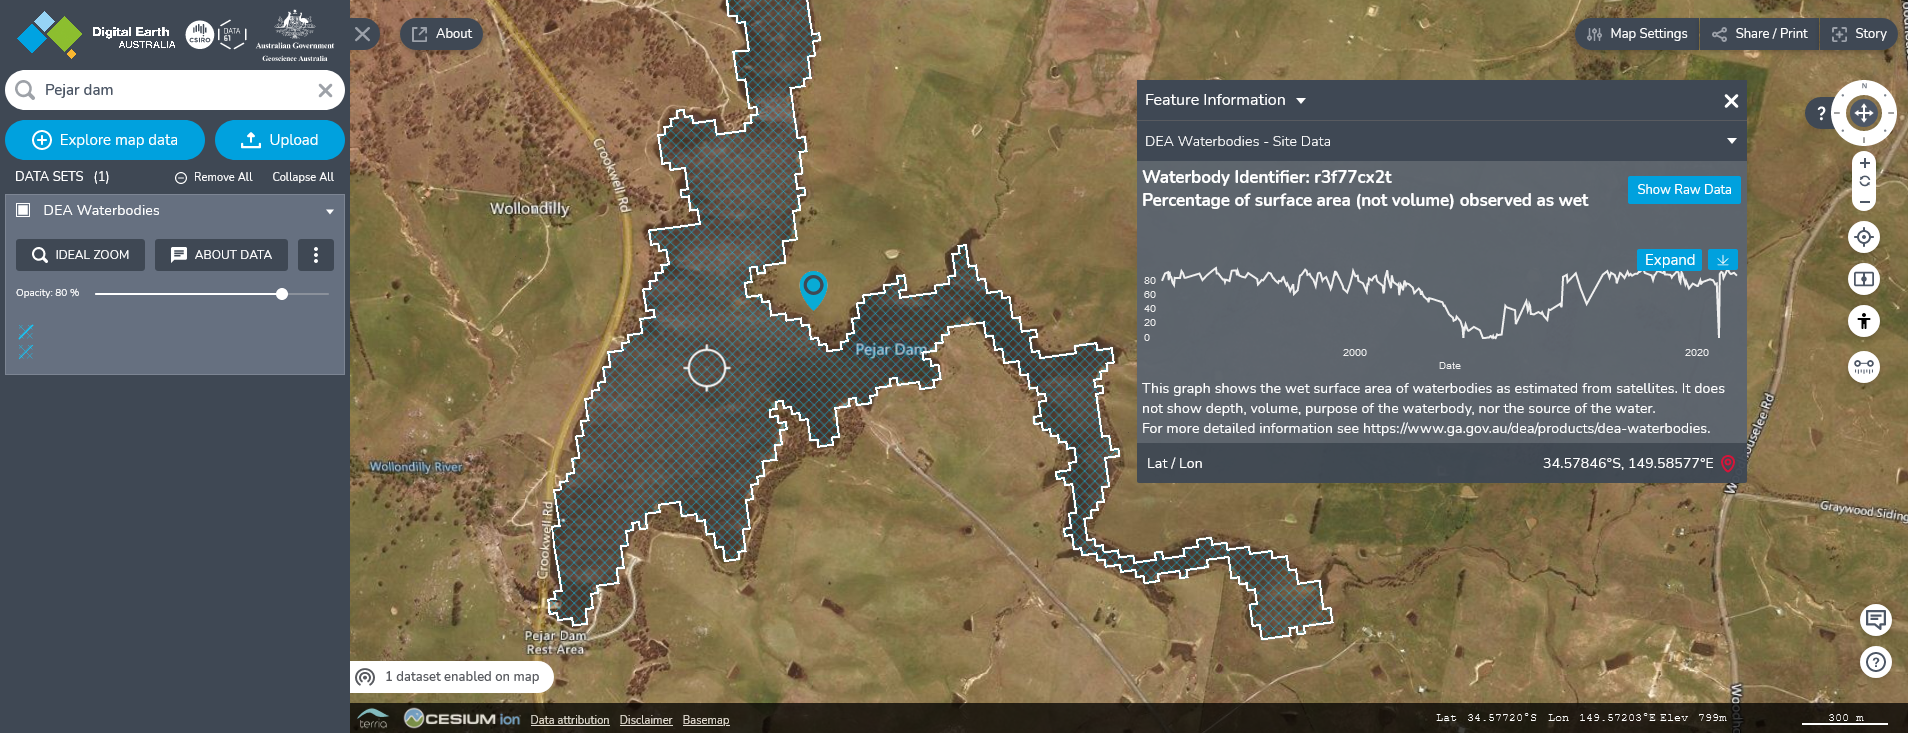<br><br>
If you know the code name for the water body of interest, you can download the CSV file directly from a website that contains all the data. As I know the code for Pejar Dam is r3f77cx2t, we can use R to read the data directly from the website. The following code will read the data from the website into a data frame called pejar_data.

In [ ]:
pejar_data <- read.csv(url('https://data.dea.ga.gov.au/projects/WaterBodies/timeseries/r3f7/r3f77cx2t.csv'))
head(pejar_data)

From looking at the data, it is clear there are null values (NA), which might cause a problem with the analyses. These values are known as missing data, or null data. In this case they are present whenever the satellite did not see the water body, due to clouds or shadows getting in the way. Often when analysing data, you need to be careful to handle these null values correctly, as they are different to zero values. The following code uses the `na.omit()` function to remove the NA values and create a new "clean" data frame.

In [ ]:
pejar_clean <- na.omit(pejar_data)
head(pejar_clean)

The date column also contains the time, and was read in by R as a datatype called 'Factor'. You can see the `<fct>` at the top of the column above. We need to change the format to be a date, just as you would need to do in Excel. In R this is easy, using the `as.Date()` function.

In [ ]:
pejar_clean$Observation.Date <- as.Date(pejar_clean$Observation.Date)
head(pejar_clean)

Now we can create a plot showing how the surface water area of the dam has changed over time. 

In [ ]:
ggplot(pejar_clean, aes(x = Observation.Date, y = Wet.pixel.percentage)) +
       geom_line(colour = 'darkblue') +
       labs(x = "Date", y = "Dam water area (%)") +
       theme_bw()

The graph clearly shows the reduction in water area during the Millenium drought, and the subsequent filling of the dam. There is one obvious problem data point that should be removed from the data, where the water area drops from 77% to 0% and then jumps to 90%. This must be due to an error with the satellite image water classification algorithm, as it is not possible for a large dam to empty and fill so rapidly. The following code removes this data from the data frame, using the `subset()` function, using a set of conditions. The conditions are to filter any points where the date is greater than 2015-01-01 and the wet pixel percentage is lower than 10%. The `!` means that the subset of the dataframe is where the conditions are not met, so all rows except the problem row are in the subset. Now when we plot the data the problem value has gone.

In [ ]:
pejar_clean <- subset(pejar_clean, !(Observation.Date > as.Date('2015-01-01') & Wet.pixel.percentage < 10))

ggplot(pejar_clean, aes(x = Observation.Date, y = Wet.pixel.percentage)) +
       geom_line(colour = 'darkblue') +
       labs(x = "Date", y = "Dam water area (%)") +
       theme_bw()

Now, lets combine the rainfall data and the water area data into one figure, so we can see how they correspond. One easy way to combine two plots is to use the [cowplot](https://cran.r-project.org/web/packages/cowplot/vignettes/introduction.html) library, named after its creator Claus O Wilke. You can import this package with the following code.

In [ ]:
library(cowplot)

Now we can create each plot, assigning them to variables, which we can then combine using the `plot_grid()` function from the cowplot library. To make the graphs comparable, we need to make sure the x-axes have the same range, so we use the `xlim` argument in the `coord_cartesian()` function.

In [ ]:
spi_graph <- ggplot(rainfall_data, aes(x = date, y = spi)) +
                    geom_ribbon(aes(ymin = 0, ymax = wet), fill = "skyblue") +
                    geom_ribbon(aes(ymin = dry, ymax = 0), fill = "tomato") +
                    geom_line() +
                    geom_hline(yintercept = 0) +
                    labs(x = "", y = "SPI") +
                    theme_bw() +
                    coord_cartesian(xlim=c(min(pejar_clean$Observation.Date), max(pejar_clean$Observation.Date)))

dam_graph <- ggplot(pejar_clean, aes(x = Observation.Date, y = Wet.pixel.percentage)) +
                    geom_line(colour = 'darkblue') +
                    labs(x = "", y = "Dam water area (%)") +
                    theme_bw() +
                    coord_cartesian(xlim=c(min(pejar_clean$Observation.Date), max(pejar_clean$Observation.Date)))

plot_grid(spi_graph, dam_graph, ncol = 1, align = "v")

 We can also save this graph as a PNG file using the `ggsave()` function.

In [ ]:
combined_graphs <- plot_grid(spi_graph, dam_graph, ncol = 1, align = "v")
ggsave("pejar_timeseries.png", combined_graphs)

This is the end of the exercise. You have explored two different datasets to investigate a research question. During the millenium drought, the minimum SPI was reached and the dam became empty. All the other droughts that occured were not as extreme, or as long, and they did not result in major reductions in water area. The millenium drought really was an extreme event, during the last 30 years that Landsat satellites have been recording data, and also going back to 1950s as the rainfall data show.

***
# Final instructions #
There are a few things you need to do:
- Dont forget to answer the Moodle quiz questions for this lab.
- If you have any problems, or questions, please post on the Moodle forum.
- Save the completed notebook and download it to your computer, as SWAN scratch directories get emptied. Or you can move the files into your Cloustor directory. You can also download the graph.

***

# Further exercise #
Identify the water body names for other dams in the area, and add new code cells to create graphs and identify when the water bodies were at their lowest levels. Did all the water bodies empty at a similar time to Pejar Dam?